In [1]:
import torch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from netcal.metrics import ECE, ACE

import pickle
import random

from utils_notebook import f_probs_ovr_poe_logits_weighted, modal_probs_decreasing, modal_probs_average, \
                            modal_probs_decreasing_count, modal_probs_decreasing_relative, f_probs_ovr_poe_logits_weighted_generalized, get_scale_probs

/home/metod/miniconda3/envs/dvit/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# MODEL = 'DVT_Deit_small'
# MODEL = 'DVT_T2t_vit_12'
MODEL = 'DVT_T2t_vit_12_cifar10'

In [3]:
with open(f'output/{MODEL}.p', 'rb') as f:
    data = pickle.load(f)

In [4]:
logits, targets, anytime_classification = data
targets = targets.cpu()

In [5]:
anytime_classification

[96.02, 96.13, 96.15]

In [6]:
# type(logits), logits.shape, type(targets), targets.shape, type(anytime_classification), len(anytime_classification)

In [7]:
logits[0, 0, :].sum()

tensor(0.1078)

## 1 Anytime Performance

In [8]:
L = len(logits)
N = logits.shape[1]
C = logits.shape[-1]

In [9]:
L, N

(3, 10000)

In [10]:
probs = torch.softmax(logits, dim=2)
preds = {i: torch.argmax(probs, dim=2)[i, :] for i in range(L)}
acc = [(targets == preds[i]).sum() / len(targets) for i in range(L)]
msp = {i: torch.max(probs, dim=2).values[i, :] for i in range(L)}

In [11]:
[round(float(x), 4) for x in acc]

[0.9602, 0.9613, 0.9615]

In [12]:
[round(x, 4) for x in modal_probs_decreasing(preds, probs, L, N=N, thresholds=[-0.0001, -0.01, -0.05, -0.1, -0.2, -0.25, -0.33, -0.5], diffs_type="all").values()]

[99.94, 99.92, 99.84, 99.56, 99.12, 98.69, 81.08, 10.5]

In [13]:
probs_poe_ovr_break_ties = torch.tensor(f_probs_ovr_poe_logits_weighted(logits))
preds_poe_ovr_break_ties = {i: torch.argmax(probs_poe_ovr_break_ties, dim=2)[i, :] for i in range(L)}
acc_poe_ovr_break_ties = [(targets == preds_poe_ovr_break_ties[i]).sum() / len(targets) for i in range(L)]

In [14]:
probs_poe_ovr_break_ties_softmax_first = torch.tensor(f_probs_ovr_poe_logits_weighted(probs))
preds_poe_ovr_break_ties_softmax_first = {i: torch.argmax(probs_poe_ovr_break_ties_softmax_first, dim=2)[i, :] for i in range(L)}
acc_poe_ovr_break_ties_softmax_first = [(targets == preds_poe_ovr_break_ties_softmax_first[i]).sum() / len(targets) for i in range(L)]

In [15]:
# probs_poe_ovr_break_ties_generalized = torch.tensor(f_probs_ovr_poe_logits_weighted_generalized(logits, weights=np.array([1/6 ,2/6 ,3/6])))
T = 1.
probs_poe_ovr_break_ties_generalized = torch.tensor(f_probs_ovr_poe_logits_weighted_generalized(logits, weights=np.array([1./3. ,2./3. ,3./3.]) * T))
preds_poe_ovr_break_ties_generalized = {i: torch.argmax(probs_poe_ovr_break_ties_generalized, dim=2)[i, :] for i in range(L)}
acc_poe_ovr_break_ties_generalized = [(targets == preds_poe_ovr_break_ties_generalized[i]).sum() / len(targets) for i in range(L)]

In [16]:
[round(float(x), 4) for x in acc_poe_ovr_break_ties_generalized]

[0.9602, 0.961, 0.9617]

In [17]:
[round(x, 4) for x in modal_probs_decreasing(preds_poe_ovr_break_ties_generalized, 
                                            probs_poe_ovr_break_ties_generalized, L, N=N, thresholds=[-0.0001, -0.01, -0.05, -0.1, -0.2, -0.25, -0.33, -0.5], diffs_type="all").values()]

[0.16, 0.14, 0.02, 0.01, 0.0, 0.0, 0.0, 0.0]

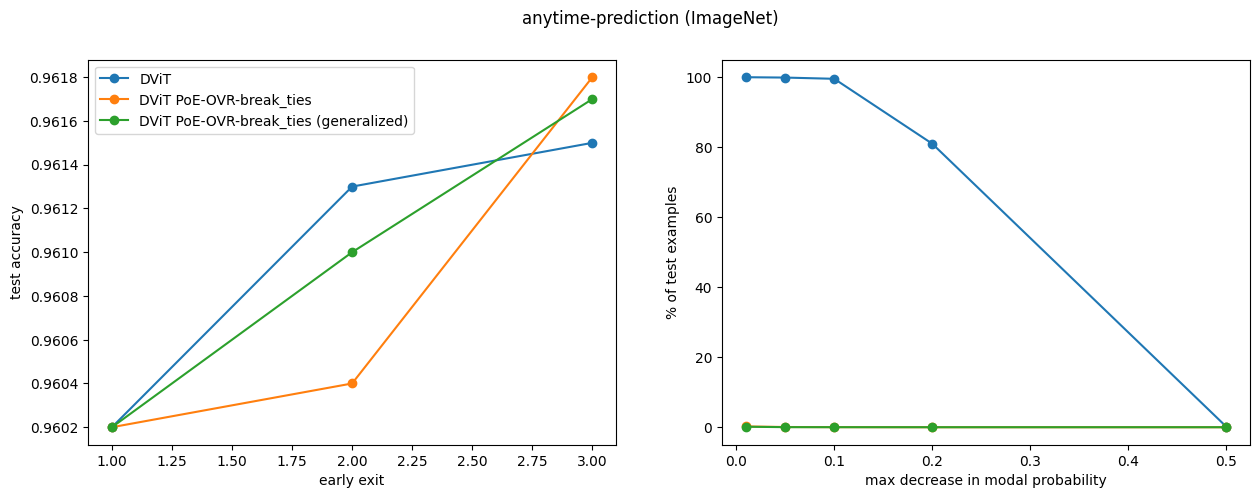

In [18]:
early_exits = [i + 1 for i in range(L)]
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(early_exits, acc, label='DViT', marker='o',)
ax[0].plot(early_exits, acc_poe_ovr_break_ties, label='DViT PoE-OVR-break_ties', marker='o')
# ax[0].plot(early_exits, acc_poe_ovr_break_ties_softmax_first, label='DViT PoE-OVR-break_ties (on probs)', marker='o')
ax[0].plot(early_exits, acc_poe_ovr_break_ties_generalized, label='DViT PoE-OVR-break_ties (generalized)', marker='o')
ax[0].legend()
# ax[0].set_title('anytime-prediction')
ax[0].set_ylabel('test accuracy')
ax[0].set_xlabel('early exit')

for _preds, _probs, label in [
                            (preds, probs, 'DViT'), 
                            (preds_poe_ovr_break_ties, probs_poe_ovr_break_ties, 'DViT PoE-OVR-break_ties'),
                            # (preds_poe_ovr_break_ties_softmax_first, probs_poe_ovr_break_ties_softmax_first, 'DViT PoE-OVR-break_ties (on probs)'),
                            (preds_poe_ovr_break_ties_generalized, probs_poe_ovr_break_ties_generalized, 'DViT PoE-OVR-break_ties (generalized)'),
                            ]:
    modal_probs = modal_probs_decreasing(_preds, _probs, layer=L, N=N)
    ax[1].plot(modal_probs.keys(), modal_probs.values(), marker='o', label=label)
# ax[1].legend()
# ax[1].set_title('anytime-prediction')
ax[1].set_xlabel('max decrease in modal probability')
ax[1].set_ylabel('% of test examples')


plt.suptitle(f'anytime-prediction (ImageNet)')
plt.show()

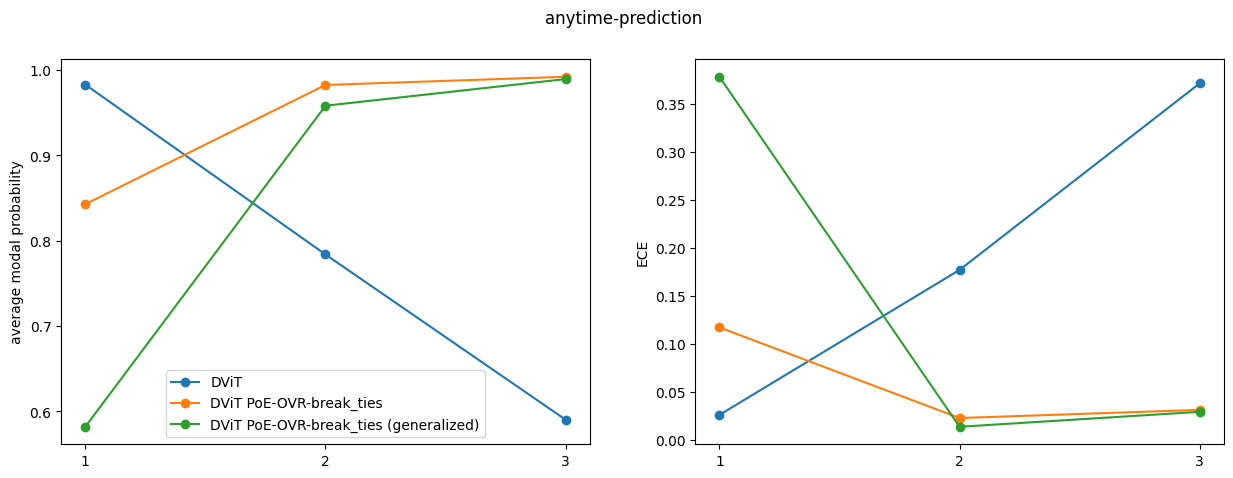

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
early_exits = [i + 1 for i in range(len(acc))]
for _preds, _probs, label in [
                            (preds, probs, 'DViT'), 
                            (preds_poe_ovr_break_ties, probs_poe_ovr_break_ties, 'DViT PoE-OVR-break_ties'),
                            # (preds_poe_ovr_break_ties_softmax_first, probs_poe_ovr_break_ties_softmax_first, 'DViT PoE-OVR-break_ties (on probs)'),
                            (preds_poe_ovr_break_ties_generalized, probs_poe_ovr_break_ties_generalized, 'DViT PoE-OVR-break_ties (generalized)'),
                            ]:
    modal_probs = modal_probs_average(_preds, _probs, L)
    ece = []
    for l in range(L):
        ece.append(ECE(bins=15).measure(_probs[l, :, :].numpy(), targets.numpy()))
    ax[0].plot(early_exits, modal_probs.numpy(), marker='o', label=label)
    ax[1].plot(early_exits, ece, marker='o', label=label)
    ax[0].set_xticks(range(1, L + 1))
    ax[1].set_xticks(range(1, L + 1))
ax[0].legend()
ax[0].set_ylabel('average modal probability')
ax[1].set_ylabel('ECE')


plt.suptitle('anytime-prediction')
plt.show()

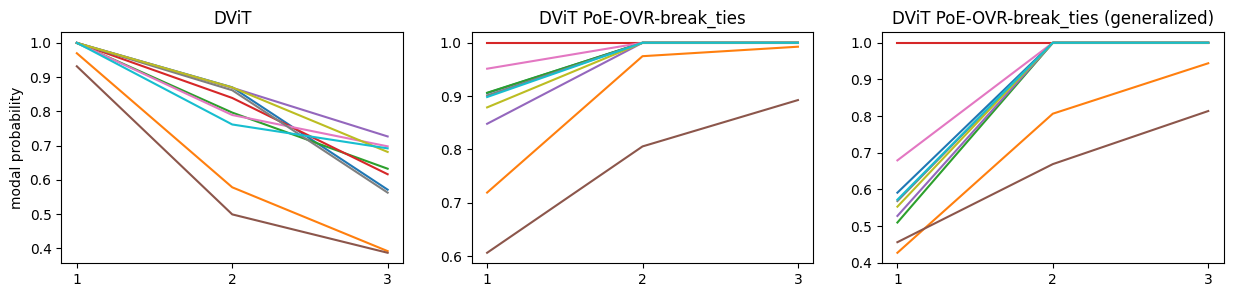

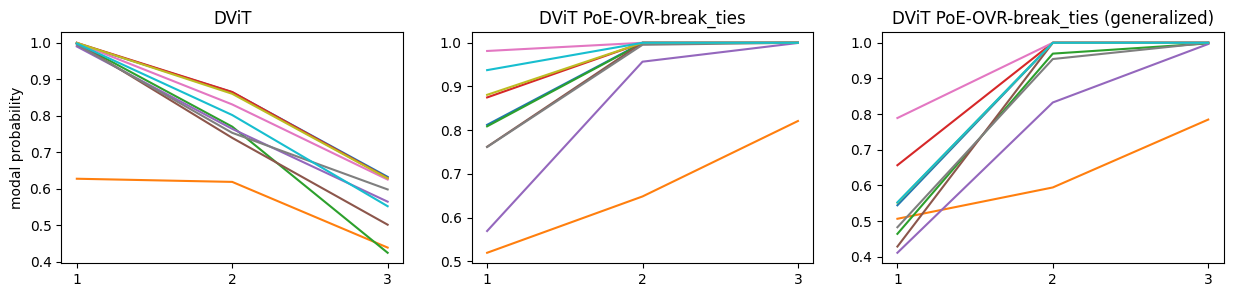

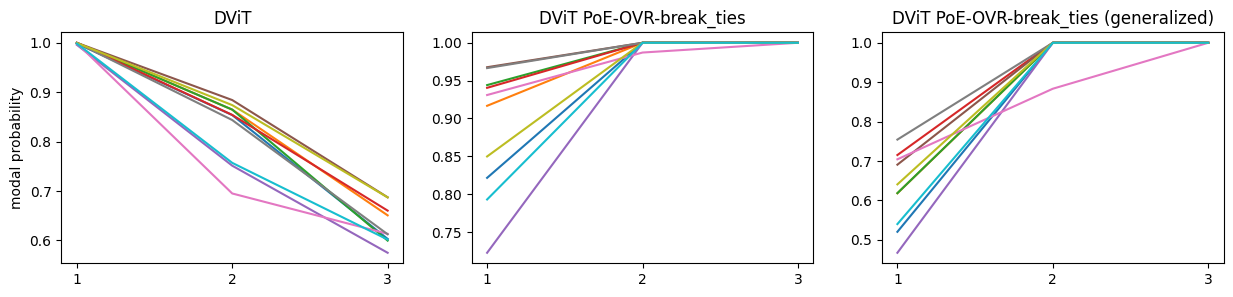

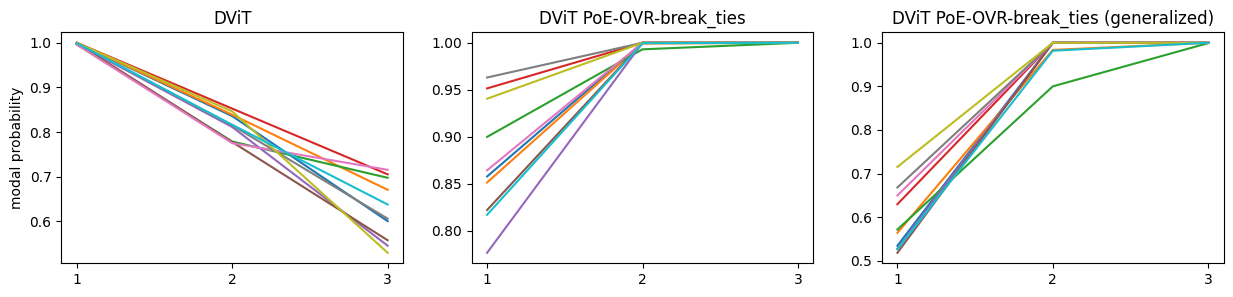

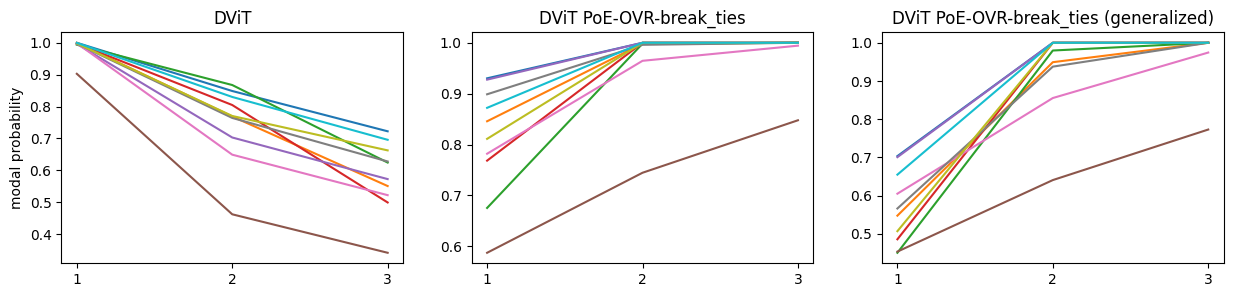

In [20]:
_preds = preds_poe_ovr_break_ties[L - 1]  # modal pred: p(\bar{y})
# _preds = targets  # probability of correct answer: p(y^*)
_probs = probs_poe_ovr_break_ties

for _ in range(5):
    fig, ax = plt.subplots(1, 3, figsize=(15, 3))
    samples = random.sample(range(N), 10)
    # print(samples)
    for i in samples:
        probs_i = _probs[:, i, _preds[i]].cpu()
        probs_i_baseline = probs[:, i, preds[L - 1][i]].cpu()
        # probs_i_ = probs_poe_ovr_break_ties_softmax_first[:, i, preds_poe_ovr_break_ties_softmax_first[L - 1][i]].cpu()
        probs_i_ = probs_poe_ovr_break_ties_generalized[:, i, preds_poe_ovr_break_ties_generalized[L - 1][i]].cpu()
        ax[0].plot(list(range(1, len(probs_i_baseline) + 1)), probs_i_baseline, label=f'{i}');
        ax[1].plot(list(range(1, len(probs_i) + 1)), probs_i, label=f'{i}');
        ax[2].plot(list(range(1, len(probs_i_) + 1)), probs_i_, label=f'{i}');
        ax[0].set_xticks(range(1, len(probs_i_baseline) + 1))
        ax[1].set_xticks(range(1, len(probs_i_baseline) + 1))
        ax[2].set_xticks(range(1, len(probs_i_baseline) + 1))
    # plt.savefig('/home/metod/Desktop/PhD/year1/PoE/MSDNet-PyTorch/modal_probs.pdf')
    # plt.legend()
    ax[0].set_title('DViT')
    ax[1].set_title('DViT PoE-OVR-break_ties')
    ax[2].set_title('DViT PoE-OVR-break_ties (generalized)')
    ax[0].set_ylabel('modal probability')
    plt.show()

In [19]:
print('% of test examples with decreasing modal probability trajectory')
print(f'DViT: {(modal_probs_decreasing_count(preds, probs, layer=L, N=N) / N) * 100:.2f} %') 
print(f'DViT PoE-OVR-break_ties: {(modal_probs_decreasing_count(preds_poe_ovr_break_ties, probs_poe_ovr_break_ties, layer=L, N=N) / N) * 100:.2f} %') 

% of test examples with decreasing modal probability trajectory
DViT: 59.68 %
DViT PoE-OVR-break_ties: 0.00 %


In [20]:
THRES = [0.01, 0.05, 0.1, 0.2, 0.3]

decrease_rel_probs = modal_probs_decreasing_relative(preds, probs, layer=L, N=N)
decrease_rel_probs_poe_ovr_break_ties = modal_probs_decreasing_relative(preds_poe_ovr_break_ties, probs_poe_ovr_break_ties, layer=L, N=N)

decreases_rel_probs, decreases_rel_probs_poe_ovr_break_ties = [], []
for thres in THRES:
    decreases_rel_probs.append(sum([1 for i in decrease_rel_probs if i < -thres]) / len(decrease_rel_probs))
    decreases_rel_probs_poe_ovr_break_ties.append(sum([1 for i in decrease_rel_probs_poe_ovr_break_ties if i < -thres]) / len(decrease_rel_probs_poe_ovr_break_ties))

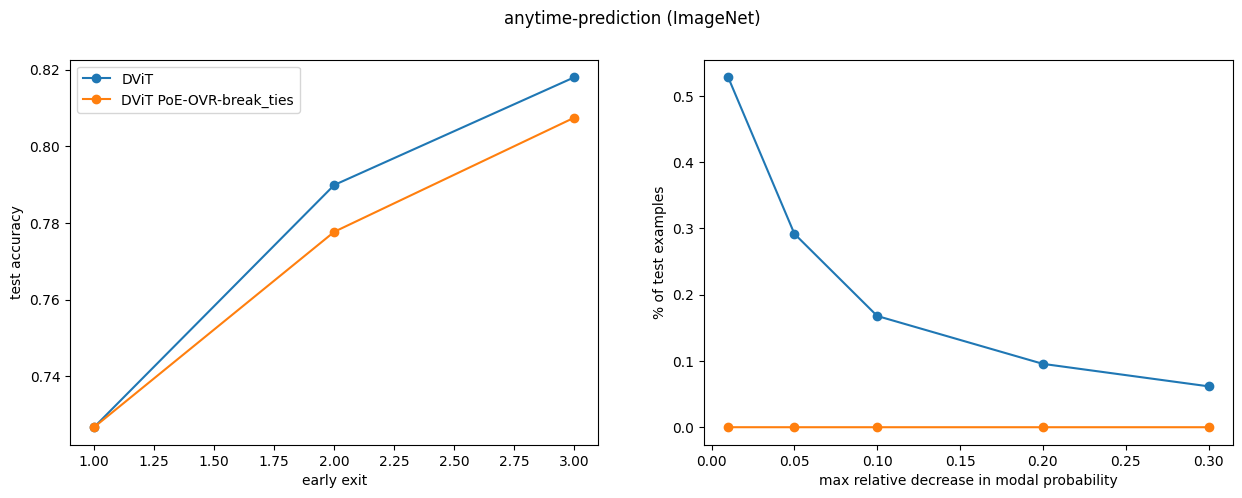

In [21]:
early_exits = [i + 1 for i in range(L)]
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(early_exits, acc, label='DViT', marker='o',)
ax[0].plot(early_exits, acc_poe_ovr_break_ties, label='DViT PoE-OVR-break_ties', marker='o')
ax[0].legend()
ax[0].set_ylabel('test accuracy')
ax[0].set_xlabel('early exit')


ax[1].plot(THRES, decreases_rel_probs, marker='o', label='DViT')
ax[1].plot(THRES, decreases_rel_probs_poe_ovr_break_ties, marker='o', label='DViT PoE-OVR-break_ties')
ax[1].set_xlabel('max relative decrease in modal probability')
ax[1].set_ylabel('% of test examples')

plt.suptitle(f'anytime-prediction (ImageNet)')
plt.show()

In [22]:
# thres_dict = {}
# for thres in [0., 1., 2., 5.]:
#     _probs = torch.tensor(f_probs_ovr_poe_logits_weighted(logits, threshold=thres))
#     _preds = {i: torch.argmax(_probs, dim=2)[i, :] for i in range(L)}
#     _acc = [(targets == _preds[i]).sum() / len(targets) for i in range(L)]
#     _modal_probs = modal_probs_decreasing(_preds, _probs, L, N=N)

#     groud_truth_coverage = {l: 0 for l in range(L)}
#     predictive_set_size = {l: [] for l in range(L)}
#     for l in range(L):
#         for n in range(N):
#             if _probs[l, n, targets[n]] > 0.:
#                 groud_truth_coverage[l] += 1
#             predictive_set_size[l].append((_probs[l, n, :] > 0).sum())

#     predictive_set_size = {l: torch.stack(sizes, dim=0) for l, sizes in predictive_set_size.items()}
#     predictive_set_size_mean = {l: sizes.numpy().mean() for l, sizes in predictive_set_size.items()}
#     groud_truth_coverage_pct = {l: (x / N) for l, x in groud_truth_coverage.items()}
#     thres_dict[thres] = (groud_truth_coverage_pct, predictive_set_size_mean, _acc, _modal_probs)

In [23]:
# for thres, (groud_truth_coverage_pct, predictive_set_size_mean, _acc, _modal_probs) in thres_dict.items():
#     print(f'thres: {thres}')
#     print(f'ground truth coverage: {groud_truth_coverage_pct}')
#     print(f'predictive set size: {predictive_set_size_mean}')
#     print(f'accuracy: {_acc}')
#     print(f'modal probs: {_modal_probs}')
#     print('==========================================')

## 2 Temperature scaling

In [24]:
T_ARR = [ 0.2, 0.5, 1., 2., 5.]
PROBS_NAME = ['DViT', 'DViT PoE-OVR']
PROBS = [probs, probs_poe_ovr_break_ties_generalized]

In [25]:
scaled_dict = get_scale_probs(PROBS_NAME, PROBS, T_ARR, targets, C=C, L=L)

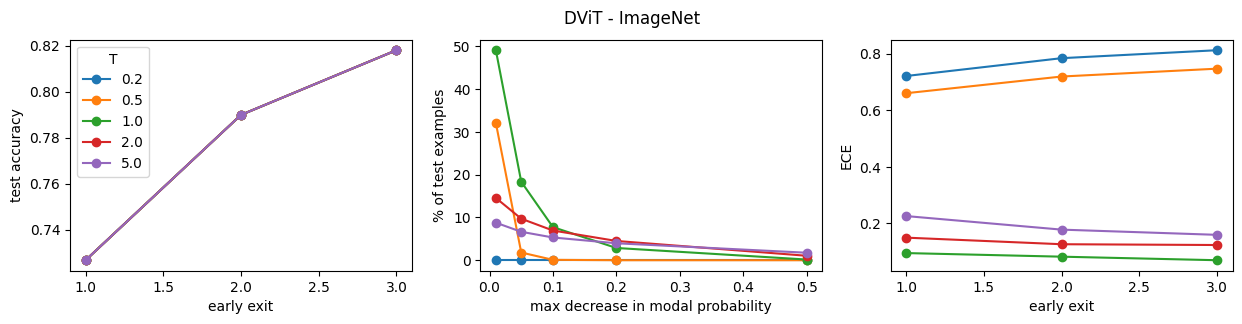

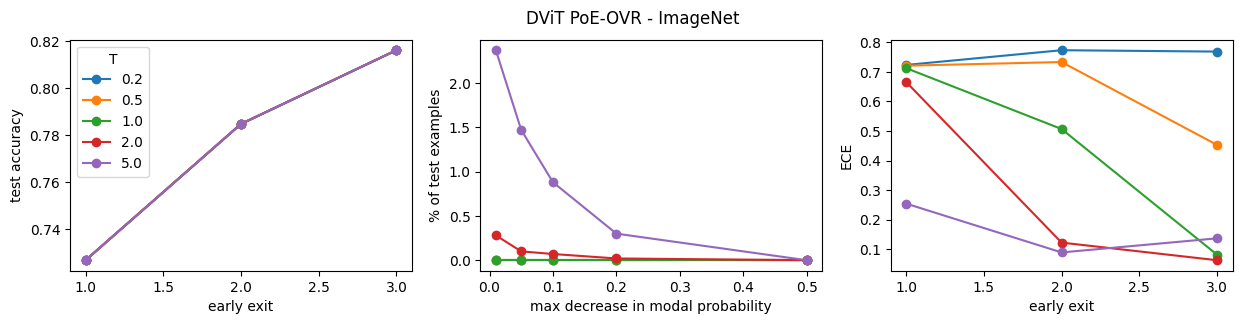

In [26]:
for prob_name in PROBS_NAME:
    fig, ax = plt.subplots(1, 3, figsize=(15, 3))
    for i, T in enumerate(T_ARR):
        _probs, _preds, _acc = scaled_dict[prob_name][T]
        ax[0].plot(list(range(1, L + 1)), _acc, label=T, marker='o')
        ax[0].set_xlabel('early exit')
        ax[0].set_ylabel('test accuracy')
        ax[0].legend(title='T')

        modal_probs = modal_probs_decreasing(_preds, _probs, L)
        ax[1].plot(modal_probs.keys(), modal_probs.values(), marker='o', label=label)

        ax[1].set_xlabel('max decrease in modal probability')
        ax[1].set_ylabel('% of test examples')

        ece = []
        for l in range(L):
            ece.append(ECE(bins=15).measure(_probs[l, :, :].numpy(), targets.numpy()))
        ax[2].plot(list(range(1, L + 1)), ece, marker='o', label=label)
        ax[2].set_xlabel('early exit')
        ax[2].set_ylabel('ECE')
        
    plt.suptitle(f'{prob_name} - ImageNet')
    plt.show()